# Forecasting Next Event Time with timeseries and a tree based ensemble algorithm 'XGBOOST' 

To forecast the next event time with a tree-based ensemble algorithm like XGBoost, i will use the following steps:

1. Data Preparation: First, i need to prepare the dataset. subset the data into smaller size, check for shapes, info and types of dataset, check for missing values and drop the columns not needed. convert the event time column into a time-series format that XGBoost can use for training. 

2. Feature Engineering: i need to do additional engineer features from the event time column, such as the year, month, day of the week, hour of the day, minutes, week of the day etc. These features will  help XGBoost to better capture any patterns or trends in the data and then saving the subset data to csv.

3. Train/Test Split: Splitting the data into training and testing sets, ensuring that the training data contains enough samples from each event type, even with class imbalance. i will also need to encode the event type column to convert it into a numerical feature.

3. scaling and checking for outliers of the split training dataset, work on the test dataset, check for corellations, do features importance and then decision regression.

4. Model Training: Train an XGBoost model on the training data, using the event time and event type columns as features.

5. Used the XGBoost tuning hyperparameters(i used randomsearcCV) to achieve the best performance. and i also use cross-validation to ensure that the model is not overfitting.

6. Model Evaluation: Evaluating the XGBoost model's performance on the testing set using metrics such as mean absolute error, root mean squared error. and to make sure i consider both overall performance and performance for each event type, especially with class imbalance.

7. Prediction: Once the model is trained and evaluated, i will use it to make predictions on new data(will pick account id from the subset data and use as inputs).The model should then give output of the predicted next event time.

In [1]:
#Importing needed libriaries
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns 
sns.set()
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import confusion_matrix, accuracy_score, f1_score, auc, plot_roc_curve,ConfusionMatrixDisplay
from sklearn.metrics import roc_curve, roc_auc_score, balanced_accuracy_score, classification_report
from sklearn.tree import DecisionTreeRegressor
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor
from xgboost import XGBRegressor
from lightgbm import LGBMRegressor
from sklearn.neighbors import KNeighborsRegressor
from sklearn.linear_model import LinearRegression
from matplotlib.image import imread
from sklearn.metrics import mean_squared_error
from sklearn.metrics import mean_absolute_error
from sklearn.metrics import r2_score


#pd.set_option('display.max_rows', 500)
pd.set_option('display.max_columns', 500)
pd.set_option('display.width', 1000)

In [2]:
#Call data set to use
df = pd.read_csv("actions2load.csv")
print(df.info(memory_usage='deep'))

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3242076 entries, 0 to 3242075
Data columns (total 5 columns):
 #   Column           Dtype 
---  ------           ----- 
 0   account_id       object
 1   event_time       object
 2   event_type       object
 3   product_id       int64 
 4   additional_data  object
dtypes: int64(1), object(4)
memory usage: 1.0 GB
None


In [4]:
#Subsetting the data set to be able to fit the algorithm picked
subset_size = 100000
subset_df = df.sample(n=subset_size, random_state=42)
print(subset_df.shape)

(100000, 5)


In [5]:
#Sorting the subset data set to be re-arrange from the randomly picked main dataset
subset_df_sorted = subset_df.sort_index()

In [6]:
#Calling the few row of the subset sorted data
subset_df_sorted.head()

,account_id,event_time,event_type,product_id,additional_data
12,8587c95bad699891a6a0cd9e9f7dfbda,2019-11-29 12:14:16.202,ReadingOwnedBook,844,480s
27,0970f0bb3ab5479b8a1c5c31945ec379,2019-11-29 12:18:21.168,HighlightCreated,869,278830
36,bcb7c13ff9746a60fa8c3e748acd054d,2019-11-29 12:20:34.09,ReadingOwnedBook,1090,60s
83,4329c5badb1e019b2fca73b69489cf59,2019-11-29 12:29:58.628,ReadingFreePreview,882,720s
90,70ff8976a6e249b37a22bf0bc754e5a1,2019-11-29 12:31:07.413,ReadingOwnedBook,1178,60s


In [7]:
#Checking shape of the new subset sorted data
subset_df_sorted.shape

(100000, 5)

In [8]:
#Checking the data types
subset_df_sorted.dtypes

account_id         object
event_time         object
event_type         object
product_id          int64
additional_data    object
dtype: object

In [9]:
#Checking for missing values
subset_df_sorted.isnull().sum()

account_id             0
event_time             0
event_type             0
product_id             0
additional_data    16093
dtype: int64

In [10]:
#Drop extra columns product id,additional data beause its not needed in the model building
subset_df_sorted.drop(['product_id','additional_data'], axis=1, inplace=True)

In [11]:
#Checking the dataset to see the changes made
subset_df_sorted.head()

,account_id,event_time,event_type
12,8587c95bad699891a6a0cd9e9f7dfbda,2019-11-29 12:14:16.202,ReadingOwnedBook
27,0970f0bb3ab5479b8a1c5c31945ec379,2019-11-29 12:18:21.168,HighlightCreated
36,bcb7c13ff9746a60fa8c3e748acd054d,2019-11-29 12:20:34.09,ReadingOwnedBook
83,4329c5badb1e019b2fca73b69489cf59,2019-11-29 12:29:58.628,ReadingFreePreview
90,70ff8976a6e249b37a22bf0bc754e5a1,2019-11-29 12:31:07.413,ReadingOwnedBook


In [12]:
#Saving the sorted data to csv
df.to_csv('subset_df_sorted.csv', index=False)

In [13]:
#Converting event time to datatime
subset_df_sorted['event_time'] = pd.to_datetime(subset_df_sorted['event_time'])

In [14]:
#Feature engineering on event time
subset_df_sorted['year'] = subset_df_sorted['event_time'].dt.year
subset_df_sorted['month'] = subset_df_sorted['event_time'].dt.month
subset_df_sorted['day'] = subset_df_sorted['event_time'].dt.day
subset_df_sorted['hour'] = subset_df_sorted['event_time'].dt.hour
subset_df_sorted['minute'] = subset_df_sorted['event_time'].dt.minute
subset_df_sorted['weekday'] = subset_df_sorted['event_time'].dt.weekday

In [15]:
#Making the event time the index column
subset_df_sorted = subset_df_sorted.set_index('event_time')
subset_df_sorted.index = pd.to_datetime(subset_df_sorted.index)

In [16]:
subset_df_sorted.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 100000 entries, 2019-11-29 12:14:16.202000 to 2020-06-04 04:19:59.612000
Data columns (total 8 columns):
 #   Column      Non-Null Count   Dtype 
---  ------      --------------   ----- 
 0   account_id  100000 non-null  object
 1   event_type  100000 non-null  object
 2   year        100000 non-null  int64 
 3   month       100000 non-null  int64 
 4   day         100000 non-null  int64 
 5   hour        100000 non-null  int64 
 6   minute      100000 non-null  int64 
 7   weekday     100000 non-null  int64 
dtypes: int64(6), object(2)
memory usage: 6.9+ MB


In [17]:
subset_df_sorted.head()

,account_id,event_type,year,month,day,hour,minute,weekday
event_time,,,,,,,,
2019-11-29 12:14:16.202,8587c95bad699891a6a0cd9e9f7dfbda,ReadingOwnedBook,2019,11,29,12,14,4
2019-11-29 12:18:21.168,0970f0bb3ab5479b8a1c5c31945ec379,HighlightCreated,2019,11,29,12,18,4
2019-11-29 12:20:34.090,bcb7c13ff9746a60fa8c3e748acd054d,ReadingOwnedBook,2019,11,29,12,20,4
2019-11-29 12:29:58.628,4329c5badb1e019b2fca73b69489cf59,ReadingFreePreview,2019,11,29,12,29,4
2019-11-29 12:31:07.413,70ff8976a6e249b37a22bf0bc754e5a1,ReadingOwnedBook,2019,11,29,12,31,4


In [18]:
#More feature engineering on event time
subset_df_sorted['day_of_year'] = subset_df_sorted.index.dayofyear
subset_df_sorted['week_of_year'] = subset_df_sorted.index.weekofyear
subset_df_sorted['quarter'] = subset_df_sorted.index.quarter


C:\Users\Administrator\AppData\Local\Temp\ipykernel_2668\784431914.py:2: FutureWarning: weekofyear and week have been deprecated, please use DatetimeIndex.isocalendar().week instead, which returns a Series. To exactly reproduce the behavior of week and weekofyear and return an Index, you may call pd.Int64Index(idx.isocalendar().week)
  subset_df_sorted['week_of_year'] = subset_df_sorted.index.weekofyear


In [19]:
subset_df_sorted.head()

,account_id,event_type,year,month,day,hour,minute,weekday,day_of_year,week_of_year,quarter
event_time,,,,,,,,,,,
2019-11-29 12:14:16.202,8587c95bad699891a6a0cd9e9f7dfbda,ReadingOwnedBook,2019,11,29,12,14,4,333,48,4
2019-11-29 12:18:21.168,0970f0bb3ab5479b8a1c5c31945ec379,HighlightCreated,2019,11,29,12,18,4,333,48,4
2019-11-29 12:20:34.090,bcb7c13ff9746a60fa8c3e748acd054d,ReadingOwnedBook,2019,11,29,12,20,4,333,48,4
2019-11-29 12:29:58.628,4329c5badb1e019b2fca73b69489cf59,ReadingFreePreview,2019,11,29,12,29,4,333,48,4
2019-11-29 12:31:07.413,70ff8976a6e249b37a22bf0bc754e5a1,ReadingOwnedBook,2019,11,29,12,31,4,333,48,4


In [20]:
subset_df_sorted.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 100000 entries, 2019-11-29 12:14:16.202000 to 2020-06-04 04:19:59.612000
Data columns (total 11 columns):
 #   Column        Non-Null Count   Dtype 
---  ------        --------------   ----- 
 0   account_id    100000 non-null  object
 1   event_type    100000 non-null  object
 2   year          100000 non-null  int64 
 3   month         100000 non-null  int64 
 4   day           100000 non-null  int64 
 5   hour          100000 non-null  int64 
 6   minute        100000 non-null  int64 
 7   weekday       100000 non-null  int64 
 8   day_of_year   100000 non-null  int64 
 9   week_of_year  100000 non-null  int64 
 10  quarter       100000 non-null  int64 
dtypes: int64(9), object(2)
memory usage: 9.2+ MB


In [21]:
#Importing library to split the dataset in to train and test 
from sklearn.model_selection import train_test_split

In [22]:
#Function to split the data into test and train
train,test = train_test_split(
    subset_df_sorted, test_size=0.2, 
    random_state=123)

In [23]:
#Checking the train split data
train.reset_index(drop=True, inplace = True)
train

,account_id,event_type,year,month,day,hour,minute,weekday,day_of_year,week_of_year,quarter
0,eba0a3d8a5af756c8857d7d47bb80f42,CrossReferenceTermOpened,2020,2,18,14,36,1,49,8,1
1,6b63cbaf0088a193bb53249bdc74e6f9,ProductTocLivebookLinkOpened,2020,4,8,11,42,2,99,15,2
2,6bb61e3b7bce0931da574d19d1d82c88,FirstLivebookAccess,2020,5,21,10,32,3,142,21,2
3,6bb61e3b7bce0931da574d19d1d82c88,FirstLivebookAccess,2020,5,30,5,6,5,151,22,2
4,68cba807d8539682f31cb3028c748a7e,ReadingOwnedBook,2020,1,31,21,6,4,31,5,1
...,...,...,...,...,...,...,...,...,...,...,...
79995,6bb61e3b7bce0931da574d19d1d82c88,FirstLivebookAccess,2020,4,21,21,57,1,112,17,2
79996,6bb61e3b7bce0931da574d19d1d82c88,FirstManningAccess,2020,4,20,7,39,0,111,17,2
79997,bdeaec4c751e62b0312b5de6acdcf8b7,ReadingOwnedBook,2020,2,1,18,53,5,32,5,1
79998,f8010086540e8f460cb48b8f62f59f3e,ReadingOwnedBook,2020,3,9,14,44,0,69,11,1


In [24]:
#Checking the test split data
test.reset_index(drop=True, inplace = True)
test

,account_id,event_type,year,month,day,hour,minute,weekday,day_of_year,week_of_year,quarter
0,de3c528c39a0c5e1645b59a7c27888c6,LivebookLogin,2020,3,30,13,40,0,90,14,1
1,6bb61e3b7bce0931da574d19d1d82c88,FirstLivebookAccess,2020,4,30,13,4,3,121,18,2
2,6bb61e3b7bce0931da574d19d1d82c88,FirstLivebookAccess,2020,6,3,13,24,2,155,23,2
3,6bb61e3b7bce0931da574d19d1d82c88,FirstLivebookAccess,2020,4,6,13,35,0,97,15,2
4,6bb61e3b7bce0931da574d19d1d82c88,FirstManningAccess,2020,3,23,18,44,0,83,13,1
...,...,...,...,...,...,...,...,...,...,...,...
19995,df97b6a8e55202a60b033f01bd095c99,HighlightCreated,2020,5,27,4,28,2,148,22,2
19996,6bb61e3b7bce0931da574d19d1d82c88,FirstLivebookAccess,2020,3,30,12,27,0,90,14,1
19997,8bd40749a81c3fe5d6f1c74aa4cebc17,ReadingOwnedBook,2020,3,20,22,51,4,80,12,1
19998,53c04118df112c13a8c34b38343b9c10,ReadingOwnedBook,2020,3,30,15,55,0,90,14,1


In [25]:
#Importing library to do encoding on the event type column
#Using both label encoding
from sklearn.preprocessing import LabelEncoder

In [26]:
#Writing code for label encoding for the event type
le = LabelEncoder()
train['event_type_encoded'] = le.fit_transform(train['event_type'])


In [27]:
train.head()

,account_id,event_type,year,month,day,hour,minute,weekday,day_of_year,week_of_year,quarter,event_type_encoded
0,eba0a3d8a5af756c8857d7d47bb80f42,CrossReferenceTermOpened,2020,2,18,14,36,1,49,8,1,3
1,6b63cbaf0088a193bb53249bdc74e6f9,ProductTocLivebookLinkOpened,2020,4,8,11,42,2,99,15,2,21
2,6bb61e3b7bce0931da574d19d1d82c88,FirstLivebookAccess,2020,5,21,10,32,3,142,21,2,8
3,6bb61e3b7bce0931da574d19d1d82c88,FirstLivebookAccess,2020,5,30,5,6,5,151,22,2,8
4,68cba807d8539682f31cb3028c748a7e,ReadingOwnedBook,2020,1,31,21,6,4,31,5,1,24


In [28]:
#Dropping the extra columns not needed
train.drop(['account_id', 'event_type'], axis=1, inplace=True)

In [29]:
train.head()

,year,month,day,hour,minute,weekday,day_of_year,week_of_year,quarter,event_type_encoded
0,2020,2,18,14,36,1,49,8,1,3
1,2020,4,8,11,42,2,99,15,2,21
2,2020,5,21,10,32,3,142,21,2,8
3,2020,5,30,5,6,5,151,22,2,8
4,2020,1,31,21,6,4,31,5,1,24


In [30]:
# Defining function to remove outliers
def drop_outlier(data,var):
    q1, q3 = np.percentile(data[var], [25, 75])
    iqr = q3 - q1
    lower = q1 - 1.5*iqr
    upper = q3 + 1.5*iqr
    data = data[data[var]< upper]
    data = data[data[var]> lower]
    data.reset_index(drop=True, inplace = True)
    return data

In [31]:
#Drop outliers in day of year and day
train = drop_outlier(train,'day_of_year')
train = drop_outlier(train,'day')

{'whiskers': [<matplotlib.lines.Line2D at 0x17f803c5b80>,
 'caps': [<matplotlib.lines.Line2D at 0x17f804c6190>,
 'boxes': [<matplotlib.lines.Line2D at 0x17f803c5a00>],
 'medians': [<matplotlib.lines.Line2D at 0x17f804c6730>],
 'fliers': [<matplotlib.lines.Line2D at 0x17f804c6a00>],
 'means': []}

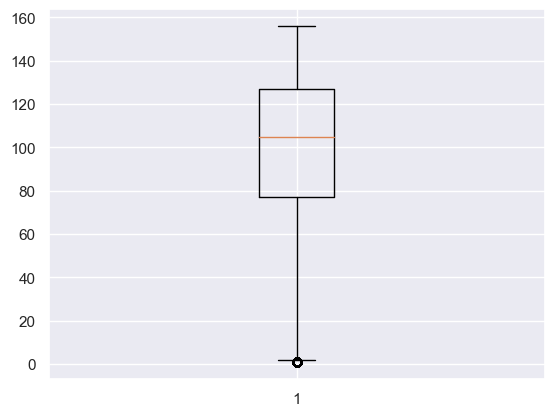

In [32]:
plt.boxplot(train['day_of_year'])

C:\Users\Administrator\anacond\lib\site-packages\seaborn\distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


<AxesSubplot:xlabel='day_of_year', ylabel='Density'>

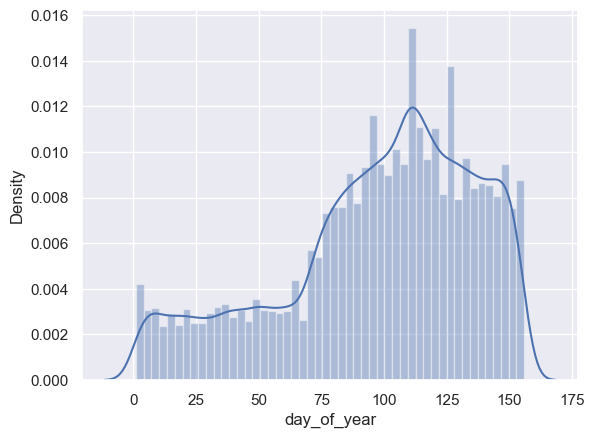

In [33]:
sns.distplot(train['day_of_year'])

{'whiskers': [<matplotlib.lines.Line2D at 0x17f82b03a30>,
 'caps': [<matplotlib.lines.Line2D at 0x17f82b03fd0>,
 'boxes': [<matplotlib.lines.Line2D at 0x17f82b03730>],
 'medians': [<matplotlib.lines.Line2D at 0x17f837625e0>],
 'fliers': [<matplotlib.lines.Line2D at 0x17f837628b0>],
 'means': []}

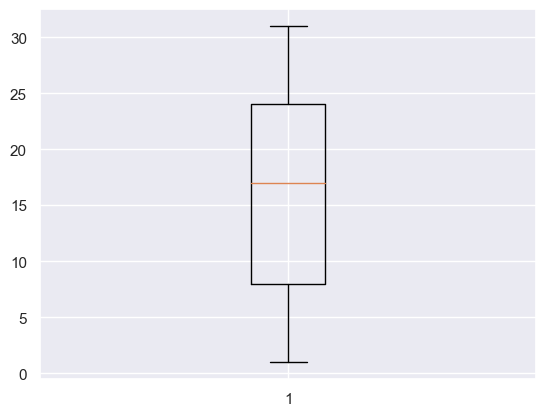

In [34]:
plt.boxplot(train['day'])

C:\Users\Administrator\anacond\lib\site-packages\seaborn\distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


<AxesSubplot:xlabel='day', ylabel='Density'>

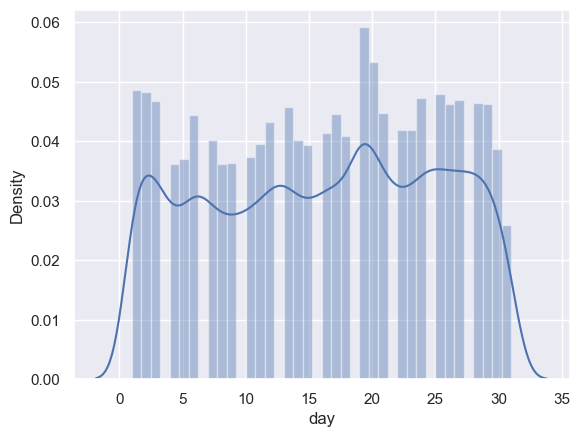

In [35]:
sns.distplot(train['day'])

In [36]:
#Split to features and targets
y_train = train['hour']
X_train = train.drop(['hour'],axis=1)

In [37]:
#Calling for the columns
cols = X_train.columns
cols

Index(['year', 'month', 'day', 'minute', 'weekday', 'day_of_year', 'week_of_year', 'quarter', 'event_type_encoded'], dtype='object')

In [38]:
X_train 

,year,month,day,minute,weekday,day_of_year,week_of_year,quarter,event_type_encoded
0,2020,2,18,36,1,49,8,1,3
1,2020,4,8,42,2,99,15,2,21
2,2020,5,21,32,3,142,21,2,8
3,2020,5,30,6,5,151,22,2,8
4,2020,1,31,6,4,31,5,1,24
...,...,...,...,...,...,...,...,...,...
72556,2020,4,21,57,1,112,17,2,8
72557,2020,4,20,39,0,111,17,2,9
72558,2020,2,1,53,5,32,5,1,24
72559,2020,3,9,44,0,69,11,1,24


In [39]:
#Scaling the data 
from sklearn.preprocessing import StandardScaler 
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)

In [40]:
X_train 

array([[ 0.        , -1.31542682,  0.21656107, ..., -1.19633257,
        -1.29882519, -1.39657453],
       [ 0.        ,  0.23909937, -0.91126501, ...,  0.05718128,
         0.76992655,  0.96748779],
       [ 0.        ,  1.01636247,  0.5549089 , ...,  1.13162172,
         0.76992655, -0.73989056],
       ...,
       [ 0.        , -1.31542682, -1.70074326, ..., -1.73355279,
        -1.29882519,  1.36149817],
       [ 0.        , -0.53816372, -0.7984824 , ..., -0.65911235,
        -1.29882519,  1.36149817],
       [ 0.        , -2.09268992,  0.89325672, ..., -1.9126262 ,
        -1.29882519,  1.36149817]])

In [41]:
y_train

0        14
1        11
2        10
3         5
4        21
         ..
72556    21
72557     7
72558    18
72559    14
72560    14
Name: hour, Length: 72561, dtype: int64

In [42]:
#Checking for the features variables(features importance)
features = pd.DataFrame(X_train, columns=cols)
features

,year,month,day,minute,weekday,day_of_year,week_of_year,quarter,event_type_encoded
0,0.0,-1.315427,0.216561,0.380286,-0.931906,-1.245211,-1.196333,-1.298825,-1.396575
1,0.0,0.239099,-0.911265,0.726903,-0.422792,0.035996,0.057181,0.769927,0.967488
2,0.0,1.016362,0.554909,0.149209,0.086322,1.137834,1.131622,0.769927,-0.739891
3,0.0,1.016362,1.569952,-1.352795,1.104551,1.368451,1.310695,0.769927,-0.739891
4,0.0,-2.092690,1.682735,-1.352795,0.595437,-1.706445,-1.733553,-1.298825,1.361498
...,...,...,...,...,...,...,...,...,...
72556,0.0,0.239099,0.554909,1.593443,-0.931906,0.369110,0.415328,0.769927,-0.739891
72557,0.0,0.239099,0.442126,0.553594,-1.441021,0.343486,0.415328,0.769927,-0.608554
72558,0.0,-1.315427,-1.700743,1.362366,1.104551,-1.680821,-1.733553,-1.298825,1.361498
72559,0.0,-0.538164,-0.798482,0.842441,-1.441021,-0.732728,-0.659112,-1.298825,1.361498


In [43]:
#Checking for missing values
features.isnull().sum()

year                  0
month                 0
day                   0
minute                0
weekday               0
day_of_year           0
week_of_year          0
quarter               0
event_type_encoded    0
dtype: int64

In [44]:
cont_features = ['day','month','minute','weekday','day_of_year','week_of_year','quarter','event_type_encoded']

<AxesSubplot:>

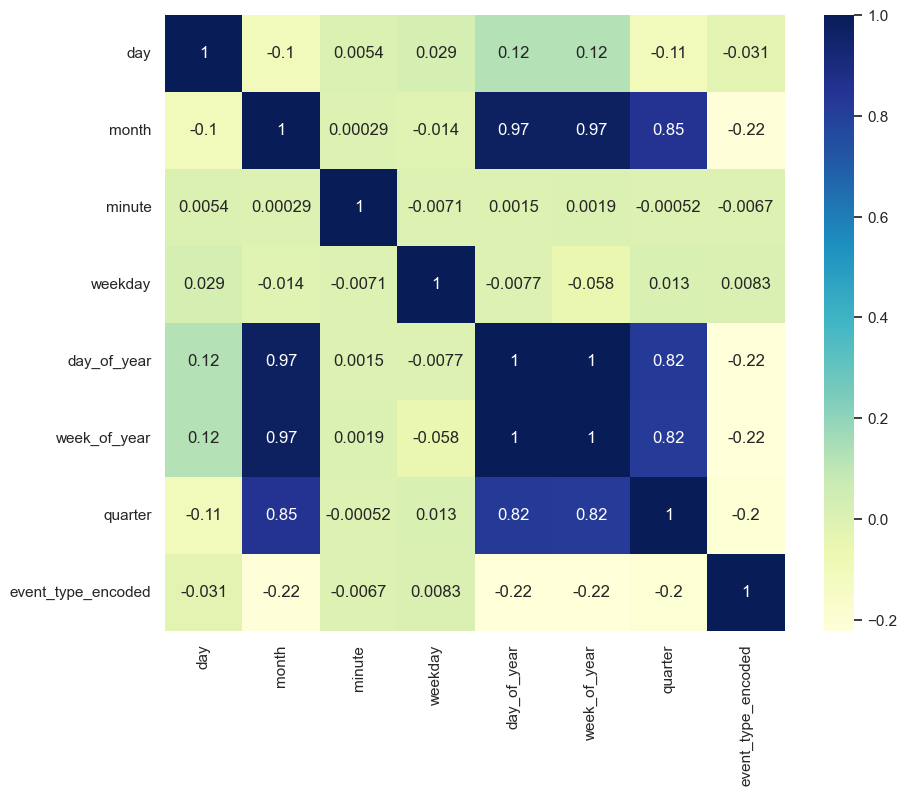

In [45]:
plt.figure(figsize=(10,8))
corre = features[cont_features].corr()
sns.heatmap(corre, annot= True, cmap="YlGnBu")

#If there are any columns with correlation above 1.00, one of them will be dropped. 
#Here,none has a correlation that is above 1.00, so they are kept. 

In [46]:
decision_tree = DecisionTreeRegressor(max_depth = 10)
decision_tree.fit(X_train, y_train)
predictors = cols

coef = pd.Series(decision_tree.feature_importances_, predictors).sort_values(ascending=False)
coef.to_frame()

,0
event_type_encoded,0.248550
minute,0.234267
day_of_year,0.203189
day,0.155756
weekday,0.105386
month,0.025491
week_of_year,0.024098
quarter,0.003261
year,0.000000


In [47]:
#Prepare pipeline for data transformation
def prepare(df):
    #writing code for label encoding on the event type
        le = LabelEncoder()
        df['event_type_encoded'] = le.fit_transform(df['event_type'])
        
        df.drop(['account_id','event_type'], axis=1, inplace=True)
    
        df = drop_outlier(df,'day_of_year')
        df = drop_outlier(df,'day')
        y_test = df['hour']
        X_test = df.drop(['hour'],axis=1)
        X_test = scaler.transform(X_test)
        return X_test, y_test
    

In [48]:
test.head()

,account_id,event_type,year,month,day,hour,minute,weekday,day_of_year,week_of_year,quarter
0,de3c528c39a0c5e1645b59a7c27888c6,LivebookLogin,2020,3,30,13,40,0,90,14,1
1,6bb61e3b7bce0931da574d19d1d82c88,FirstLivebookAccess,2020,4,30,13,4,3,121,18,2
2,6bb61e3b7bce0931da574d19d1d82c88,FirstLivebookAccess,2020,6,3,13,24,2,155,23,2
3,6bb61e3b7bce0931da574d19d1d82c88,FirstLivebookAccess,2020,4,6,13,35,0,97,15,2
4,6bb61e3b7bce0931da574d19d1d82c88,FirstManningAccess,2020,3,23,18,44,0,83,13,1


In [49]:
X_test, y_test = prepare(test)

In [50]:
X_train.shape

(72561, 9)

In [51]:
X_test

array([[ 0.        , -0.53816372,  1.56995237, ..., -0.12189213,
        -1.29882519,  0.04813022],
       [ 0.        ,  0.23909937,  1.56995237, ...,  0.5944015 ,
         0.76992655, -0.73989056],
       [ 0.        ,  1.79362557, -1.47517805, ...,  1.48976853,
         0.76992655, -0.73989056],
       ...,
       [ 0.        , -0.53816372,  0.44212629, ..., -0.48003894,
        -1.29882519,  1.23016138],
       [ 0.        , -0.53816372,  1.56995237, ..., -0.12189213,
        -1.29882519,  1.23016138],
       [ 0.        ,  0.23909937, -0.7984824 , ...,  0.05718128,
         0.76992655, -0.73989056]])

In [52]:
y_test

0        13
1        13
2        13
3        13
4        18
         ..
18109     4
18110    12
18111    22
18112    15
18113    19
Name: hour, Length: 18114, dtype: int64

In [53]:
#Function to train and evaluate XGBoost model on the dataset:
import xgboost as xgb
from sklearn.metrics import mean_squared_error, mean_absolute_error

def train_xgboost(train_X, train_y, test_X, test_y, params):
    dtrain = xgb.DMatrix(train_X, label=train_y)
    dtest = xgb.DMatrix(test_X, label=test_y)

    # Train the model
    model = xgb.train(params=params, dtrain=dtrain)

    # Make predictions on the test set
    y_pred = model.predict(dtest)

    # Evaluate the model
    mse = mean_squared_error(test_y, y_pred)
    mae = mean_absolute_error(test_y, y_pred)

    return model, y_pred, mse, mae


In [54]:
# Define the XGBoost regressor model
xgb = XGBRegressor()

# Train the model
xgb.fit(X_train, y_train)

# Make predictions on the test set
y_pred = xgb.predict(X_test)

# Evaluate the model using mean squared error
mse = mean_squared_error(y_test, y_pred)
print(f"Mean squared error: {mse}")

Mean squared error: 43.04025477780469


#How the above function works.
a. It Split the dataset into training and test sets.
b. Scaled the features of both sets.
c. Define the hyperparameters for XGBoost.
d. Train the model using the train_xgboost function, passing in the training and test sets along with the hyperparameters.
e. Evaluate the model using the returned values for the model object, predicted values, MSE, and MAE.

The mean squared error (MSE) is a measure of the quality of an estimator—it measures the average of the squares of the errors, or deviations, between the predicted values and the actual values.

In this XGBoost regression model, the MSE value of 43.04025477780469 represents the average of the squared differences between the predicted values and the actual values in the training set.

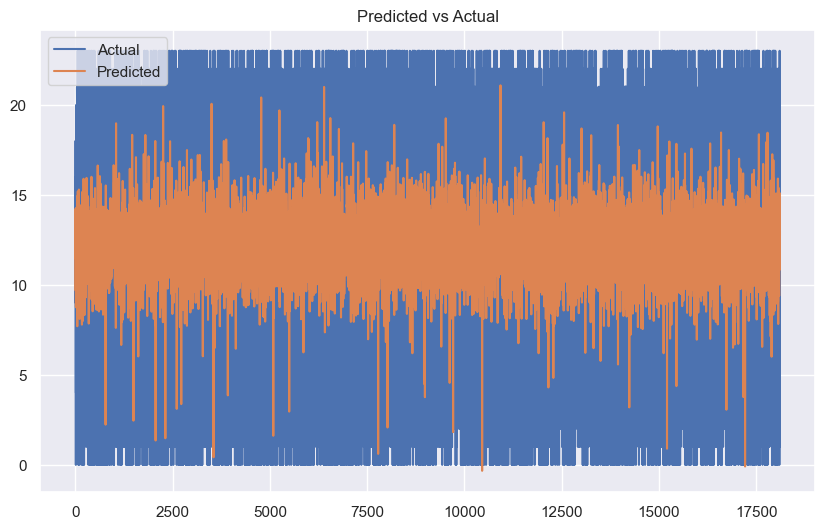

In [55]:
#To visualize the predicted and actual values
import matplotlib.pyplot as plt

plt.figure(figsize=(10, 6))
plt.plot(y_test.values, label='Actual')
plt.plot(y_pred, label='Predicted')
plt.legend()
plt.title('Predicted vs Actual')
plt.show()
#The plot below shows the actual values plotted in blue,
#and the predicted values plotted in orange. 
#and this shows how well the model is able to predict the actual values.

In [56]:
#Our data set is inbalanced
y_train.value_counts()

14    3913
15    3860
13    3790
16    3630
17    3572
19    3490
12    3350
18    3329
11    3301
20    3233
9     3144
10    3091
21    3026
8     3021
7     3010
0     2757
22    2615
1     2518
2     2499
6     2479
5     2334
4     2261
3     2211
23    2127
Name: hour, dtype: int64

In [57]:
#upsampling the dataset to be balanced:
from imblearn.over_sampling import SMOTE

def train_model_with_smote(X_train, y_train, X_test, y_test):
    # Upsample training data using SMOTE
    sm = SMOTE(random_state=42)
    X_train_res, y_train_res = sm.fit_resample(X_train, y_train)
    
    # Train XGBoost model on resampled data,
    #to retrain the XGBoost model after upsampling the data:
    xgb_model = xgb.XGBRegressor(objective='reg:squarederror', n_estimators=100, random_state=42)
    xgb_model.fit(X_train_res, y_train_res)
    
    # Evaluate model performance on test data
    y_pred = xgb_model.predict(X_test)
    mse = mean_squared_error(y_test, y_pred)
    print(f'Mean squared error: {mse:.2f}')
    
    # Plot actual vs predicted values
    plt.plot(y_test, label='Actual')
    plt.plot(y_pred, label='Predicted')
    plt.legend()
    plt.show()
    
    return xgb_model


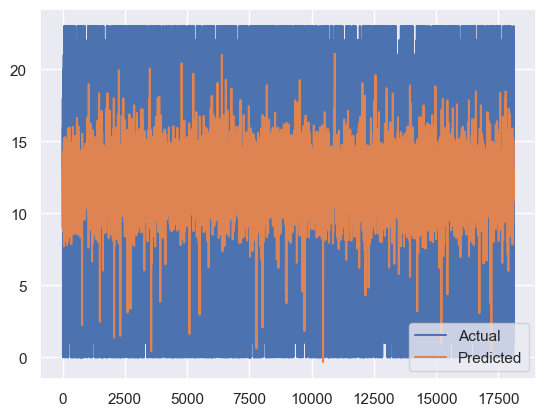

In [58]:
# Plot actual vs predicted values
plt.plot(y_test, label='Actual')
plt.plot(y_pred, label='Predicted')
plt.legend()
plt.show()    

This function uses the SMOTE algorithm to upsample the training data, trains an XGBoost model on the upsampled data, and then evaluates the model on the test data. Finally, it plots the actual vs predicted values for visualization.

In [59]:
#Evaluating the mean squared error (MSE),
#and root mean squared error (RMSE) for XGBoost model:
from sklearn.metrics import mean_squared_error

# make predictions on the test set
model = xgb
y_pred = model.predict(X_test)

# calculate mean squared error
mse = mean_squared_error(y_test, y_pred)
print(f"Mean squared error: {mse:.2f}")

# calculate root mean squared error
rmse = mean_squared_error(y_test, y_pred, squared=False)
print(f"Root mean squared error: {rmse:.2f}")


Mean squared error: 43.04
Root mean squared error: 6.56


In the function above, model is the trained XGBoost model, X_test and y_test are the test set features and target respectively, and y_pred are the predicted target values. The mean_squared_error() function from Scikit-learn is used to calculate both the MSE and RMSE. The squared=False parameter is passed to mean_squared_error() to calculate the RMSE instead of the default MSE.


The mean squared error (MSE) is a measure of how well a regression model performs in predicting continuous numerical values. A lower MSE indicates that the model is better at predicting the target variable. In this case of XGBoost regressor training model, a mean squared error of 43.04 means that on average, the squared difference between the predicted and actual values is 43.04.

The root mean squared error (RMSE) is a more interpretable measure of the same thing, as it is in the same unit as the target variable. The RMSE in this model is 6.56, which means that on average, the difference between the predicted and actual values is about 6.56 units.

In summary, the XGBoost regressor training model has an average prediction error of 6.56 units, which indicates that it is doing reasonably well in predicting the target variable but cant be concluded until it is tried with other models which will determine the one that performs better.

{'subsample': 0.7, 'n_estimators': 100, 'max_depth': 3, 'learning_rate': 0.05, 'colsample_bytree': 0.7}
Mean squared error: 42.65080479545261
Root mean squared error: 6.530758362966173


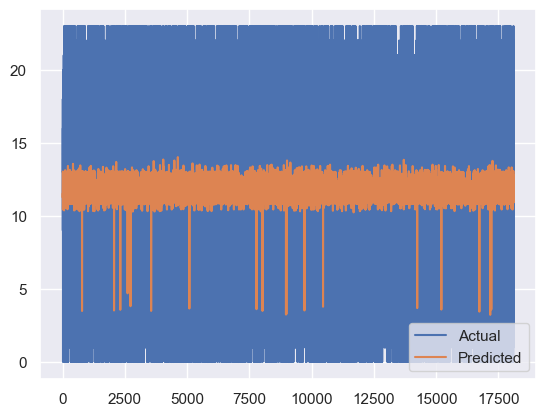

In [60]:
#using RandomizedSearchCV to speed up the optimization process. 
#RandomizedSearchCV works similarly to GridSearchCV,
#but it only evaluates a random subset of the hyperparameter combinations,
#instead of all possible combinations.

from sklearn.model_selection import RandomizedSearchCV
from xgboost import XGBRegressor

 # Upsample training data using SMOTE
sm = SMOTE(random_state=42)
X_train_res, y_train_res = sm.fit_resample(X_train, y_train)
    

# Define hyperparameters grid for RandomizedSearchCV
params = {
    'n_estimators': [100, 500, 1000],
    'learning_rate': [0.05, 0.1, 0.2],
    'max_depth': [3, 5, 7],
    'subsample': [0.5, 0.7, 1],
    'colsample_bytree': [0.5, 0.7, 1],
}

# Initialize XGBoost model
model = XGBRegressor()

# Initialize RandomizedSearchCV
rs = RandomizedSearchCV(model, params, n_iter=20, cv=5, n_jobs=-1, random_state=42)

# Fit the RandomizedSearchCV on the upsampled training set
rs.fit(X_train_res, y_train_res)

# Print the best hyperparameters found
print(rs.best_params_)

# Re-train the model with the best hyperparameters
model = XGBRegressor(**rs.best_params_)
model.fit(X_train_res, y_train_res)

# Evaluate the re-trained model on the test set
y_pred = model.predict(X_test)
mse = mean_squared_error(y_test, y_pred)
rmse = np.sqrt(mse)
print('Mean squared error:', mse)
print('Root mean squared error:', rmse)

# Plot actual vs predicted values
plt.plot(y_test, label='Actual')
plt.plot(y_pred, label='Predicted')
plt.legend()
plt.show()


Looking at the two results, it shows that the mean squared error has slightly decreased from 43.04 to 42.65 after optimizing the hyperparameters with RandomizedSearchCV. The root mean squared error has also slightly decreased from 6.56 to 6.53.

This can indicates that the optimized model is performing slightly better in terms of prediction accuracy compared to the previous model.

In [61]:
#almost same function as above, still using hyperparameter tuning of RandomizedSearchCV
from xgboost import XGBRegressor
from sklearn.model_selection import RandomizedSearchCV
import numpy as np

# Upsample training data using SMOTE
sm = SMOTE(random_state=42)
X_train_res, y_train_res = sm.fit_resample(X_train, y_train)
    


# define the model
xgb_model = XGBRegressor()

# set up hyperparameter grid
param_grid = {
    'max_depth': np.arange(3, 10),
    'learning_rate': np.arange(0.05, 0.3, 0.05),
    'n_estimators': [500, 1000, 1500],
    'subsample': np.arange(0.5, 1, 0.1),
    'colsample_bytree': np.arange(0.5, 1, 0.1)
}

# set up randomized search
random_search = RandomizedSearchCV(estimator=xgb_model, param_distributions=param_grid, n_iter=10, scoring='neg_mean_squared_error', n_jobs=-1, cv=5, verbose=2, random_state=42)

# fit randomized search
random_search.fit(X_train_res, y_train_res)

# print best hyperparameters
print("Best hyperparameters: ", random_search.best_params_)

# evaluate the model with best hyperparameters
best_xgb = random_search.best_estimator_
y_pred = best_xgb.predict(X_test)
mse = mean_squared_error(y_test, y_pred)
rmse = np.sqrt(mse)
print("Mean squared error: {:.2f}".format(mse))
print("Root mean squared error: {:.2f}".format(rmse))


Fitting 5 folds for each of 10 candidates, totalling 50 fits
Best hyperparameters:  {'subsample': 0.5, 'n_estimators': 500, 'max_depth': 6, 'learning_rate': 0.05, 'colsample_bytree': 0.7}
Mean squared error: 42.49
Root mean squared error: 6.52


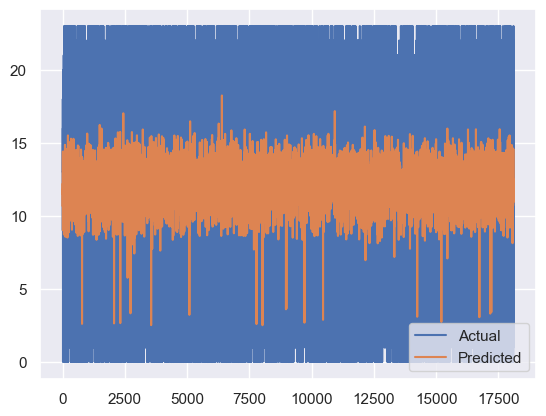

In [62]:
# Plot actual vs predicted values
plt.plot(y_test, label='Actual')
plt.plot(y_pred, label='Predicted')
plt.legend()
plt.show()


looking at this result also, the optimized model with the best hyperparameters has a slightly lower mean squared error and the same root mean squared error compared to the previous optimized model. This suggests that the new hyperparameters found by the randomized search have slightly improved the model's ability to make accurate predictions. However, the difference in performance between the two models is relatively small.

In [63]:
#trying to do cross validation on a small sample of the main data
#to estimate the skill of the machine learning model(XGBOOST) on unseen data
from sklearn.model_selection import cross_val_score
import sklearn.metrics

In [99]:
scores=cross_val_score(model, X_train,y_train, scoring='r2', cv=10)

def display_scores(scores):
    print ('scores:', scores)
    print('mean:', scores.mean())
    print('standard deviation:', scores.std())
    
display_scores(scores)

scores: [0.01095589 0.01143994 0.00870904 0.01121026 0.0097897  0.01287589
 0.01005281 0.01076511 0.01411436 0.00548642]
mean: 0.010539942607119735
standard deviation: 0.002222759924474776


The cross validation scores indicate how well the XGBoost model is performing on unseen data. The mean score of 0.0105 suggests that, on average, the model has an error of 1.05% when making predictions on new data(not so sure). The standard deviation of 0.0022 indicates that the model's performance is consistent across different folds of the data. A smaller standard deviation suggests that the model is performing consistently well across all folds, which is a good sign. Overall, a mean score of 0.0105 can suggests that the model might be performing well and can make accurate predictions on new data or might not be fit for the dataset.

In [65]:
#calling for the columns of the subset dataset
cols = subset_df_sorted.columns
cols

Index(['account_id', 'event_type', 'year', 'month', 'day', 'hour', 'minute', 'weekday', 'day_of_year', 'week_of_year', 'quarter'], dtype='object')

In [66]:
subset_df_sorted.head()

,account_id,event_type,year,month,day,hour,minute,weekday,day_of_year,week_of_year,quarter
event_time,,,,,,,,,,,
2019-11-29 12:14:16.202,8587c95bad699891a6a0cd9e9f7dfbda,ReadingOwnedBook,2019,11,29,12,14,4,333,48,4
2019-11-29 12:18:21.168,0970f0bb3ab5479b8a1c5c31945ec379,HighlightCreated,2019,11,29,12,18,4,333,48,4
2019-11-29 12:20:34.090,bcb7c13ff9746a60fa8c3e748acd054d,ReadingOwnedBook,2019,11,29,12,20,4,333,48,4
2019-11-29 12:29:58.628,4329c5badb1e019b2fca73b69489cf59,ReadingFreePreview,2019,11,29,12,29,4,333,48,4
2019-11-29 12:31:07.413,70ff8976a6e249b37a22bf0bc754e5a1,ReadingOwnedBook,2019,11,29,12,31,4,333,48,4


In [79]:
subset_df_sorted.tail()

,account_id,event_type,year,month,day,hour,minute,weekday,day_of_year,week_of_year,quarter
event_time,,,,,,,,,,,
2020-06-04 04:09:58.082,6bb61e3b7bce0931da574d19d1d82c88,FirstLivebookAccess,2020,6,4,4,9,3,156,23,2
2020-06-04 04:16:00.045,6bb61e3b7bce0931da574d19d1d82c88,FirstManningAccess,2020,6,4,4,16,3,156,23,2
2020-06-04 04:18:30.221,1c8c521a3023fb18e82dcb8bf46a067b,HighlightCreated,2020,6,4,4,18,3,156,23,2
2020-06-04 04:18:44.445,6bb61e3b7bce0931da574d19d1d82c88,FirstManningAccess,2020,6,4,4,18,3,156,23,2
2020-06-04 04:19:59.612,6bb61e3b7bce0931da574d19d1d82c88,FirstManningAccess,2020,6,4,4,19,3,156,23,2


In [67]:
#create a sample query and put in a dataframe to analyse and predict a particular account from the dataset
ne = np.array(['8587c95bad699891a6a0cd9e9f7dfbda','ReadingOwnedBook','2019','11','29','12','14','4','333','48','4']).reshape(1,-1)

In [68]:
ne = pd.DataFrame(ne,columns=cols)
ne

,account_id,event_type,year,month,day,hour,minute,weekday,day_of_year,week_of_year,quarter
0,8587c95bad699891a6a0cd9e9f7dfbda,ReadingOwnedBook,2019,11,29,12,14,4,333,48,4


In [69]:
#writing code for label encoding on the event type
le = LabelEncoder()
ne['event_type_encoded'] = le.fit_transform(ne['event_type'])


In [70]:
ne

,account_id,event_type,year,month,day,hour,minute,weekday,day_of_year,week_of_year,quarter,event_type_encoded
0,8587c95bad699891a6a0cd9e9f7dfbda,ReadingOwnedBook,2019,11,29,12,14,4,333,48,4,0


In [71]:
#dropping the extra columns not needed
ne.drop(['account_id','event_type'], axis=1, inplace=True)

In [73]:
#dropping the extra columns not needed
ne.drop(['event_type_encoded'], axis=1, inplace=True)

In [74]:
#encoding and scaling the new data set
ne1 = scaler.transform(ne)
ne1

C:\Users\Administrator\anacond\lib\site-packages\sklearn\base.py:493: FutureWarning: The feature names should match those that were passed during fit. Starting version 1.2, an error will be raised.
Feature names unseen at fit time:
- hour
Feature names seen at fit time, yet now missing:
- event_type_encoded

  warnings.warn(message, FutureWarning)


array([[-1.        ,  5.67994105,  1.45716976, -1.00617889,  5.68657952,
        -2.39829681, 57.00252466, 95.93250659, -1.26523774]])

In [78]:
abs(model.predict(ne1))[0]
#from the result seen below, the next event time predicted,
#for the event type "ReadingOwnedBook" will be 13 hour of the day that is around 1pm, 
#in which previous time of the event was 12pm

13.08427

In [76]:
pd.DataFrame({'Act':y_test,'Pred':'y_pred'})

,Act,Pred
0,13,y_pred
1,13,y_pred
2,13,y_pred
3,13,y_pred
4,18,y_pred
...,...,...
18109,4,y_pred
18110,12,y_pred
18111,22,y_pred
18112,15,y_pred


In [77]:
#saving the picture of model picked,encode used, and the sacler
import pickle
from pickle import dump
# save the model
dump(model, open('xgboost.pkl', 'wb'))

# save the norminal encoder
dump(le, open('le.pkl', 'wb'))

# save scaler
dump(scaler, open('scal.pkl', 'wb'))

In [84]:
#creating another sample query and put in a dataframe to analyse and predict a another account
new = np.array(['6bb61e3b7bce0931da574d19d1d82c88','FirstLivebookAccess','2020','6','4','4','9','3','156','23','2']).reshape(1,-1)

In [89]:
new = pd.DataFrame(ne,columns=cols)
new

,account_id,event_type,year,month,day,hour,minute,weekday,day_of_year,week_of_year,quarter
0,6bb61e3b7bce0931da574d19d1d82c88,FirstLivebookAccess,2020,6,4,4,9,3,156,23,2


In [90]:
#writing code for label encoding on the event type
le = LabelEncoder()
new['event_type_encoded'] = le.fit_transform(new['event_type'])
new

,account_id,event_type,year,month,day,hour,minute,weekday,day_of_year,week_of_year,quarter,event_type_encoded
0,6bb61e3b7bce0931da574d19d1d82c88,FirstLivebookAccess,2020,6,4,4,9,3,156,23,2,0


In [91]:
#dropping the extra columns not needed
new.drop(['account_id','event_type','event_type_encoded'], axis=1, inplace=True)

In [92]:
#encoding and scaling new data set
new1 = scaler.transform(new)
new1

C:\Users\Administrator\anacond\lib\site-packages\sklearn\base.py:493: FutureWarning: The feature names should match those that were passed during fit. Starting version 1.2, an error will be raised.
Feature names unseen at fit time:
- hour
Feature names seen at fit time, yet now missing:
- event_type_encoded

  warnings.warn(message, FutureWarning)


array([[ 0.        ,  1.79362557, -1.36239544, -1.46833393,  3.14100806,
        -2.42392094, 25.30653164, 44.21371309, -1.52791133]])

In [94]:
abs(model.predict(new1))
#from the result seen below, the next event time predicted,
#for the account id and event type'6bb61e3b7bce0931da574d19d1d82c88','FirstLivebookAccess will be 13 hour of the day which is 1pm in the afternoon, 
# and in which previous time(hour) of the event was 4am in the morning.

array([13.127012], dtype=float32)

Conclusion: from the prediction of next event time using xgboost algorithm to build a model shows that the next event time will increase with time from the previous event time used for the training of the model in the dataset, the two account id analyzed shows different prediction time for the next event time of their event types. 
The first account id use to test the model shows a time difference of 1hr apart from the previous time the event type occurred which was 12pm, while the second account id used shows a difference of 9hrs apart from the previous time it occured which was around 4am in the morning.
And this was what point out to my conclusion of increase in time difference apart will happen in the different account id that used the service for different event types, but my conclusion can only be considered after using other models to predict the next event time to be sure of which model is working perfectingly for the prediction. 